# Discovery of Writing Differences - Neural Networks Representation

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

## Reading In the Library and Prep for NN

In this part, reading the .pkl file. 

In [2]:
library_select = pd.read_pickle('../data/library_select01.pkl')

In [3]:
library_select.shape

(651, 12)

Next, extract authors, create dictionary to convert authors name to numeric values (for predictions) and add a column with that.

In [4]:
select_authors = list(library_select.sort_values(by='authorcentury')['author'].unique())

authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}
#num_to_authors = {v: k for k, v in authors_to_num.items()}

library_select['author_num'] = library_select['author'].map(authors_to_num)

## Sklearn NN

First round of neural network analysis, using sklearn.

In [5]:
X = library_select[['book_content']]
y = library_select['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'relu',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [8]:
# pipe_nn.fit(X_train['book_content'], y_train)
y_pred = pipe_nn.predict(X_test['book_content'])

print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
print('----- confusion matrix ------')
print(confusion_matrix(y_test, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y_test, y_pred))

# this below ran for almost 2 hours and didn't finish yet...
# pipe_nn.fit(X['book_content'], y)
# y_pred = pipe_nn.predict(X['book_content'])

# print('accuracy score:', accuracy_score(y, y_pred), '\n')
# print('----- confusion matrix ------')
# print(confusion_matrix(y, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y, y_pred))

Iteration 1, loss = 2.05760069
Iteration 2, loss = 0.21752568
Iteration 3, loss = 0.04001671
Iteration 4, loss = 0.01544992
Iteration 5, loss = 0.01075980
Iteration 6, loss = 0.00938157
Iteration 7, loss = 0.00869037
Iteration 8, loss = 0.00810409
Iteration 9, loss = 0.00770447
Iteration 10, loss = 0.00711750
Iteration 11, loss = 0.00670056
Iteration 12, loss = 0.00627428
Iteration 13, loss = 0.00583835
Iteration 14, loss = 0.00546611
Iteration 15, loss = 0.00517065
Iteration 16, loss = 0.00482834
Iteration 17, loss = 0.00443677
Iteration 18, loss = 0.00418134
Iteration 19, loss = 0.00397561
Iteration 20, loss = 0.00369328
Iteration 21, loss = 0.00362501
Iteration 22, loss = 0.00345571
Iteration 23, loss = 0.00344258
Iteration 24, loss = 0.00349978
Iteration 25, loss = 0.00337683
Iteration 26, loss = 0.00316837
Iteration 27, loss = 0.00306236
Iteration 28, loss = 0.00296979
Iteration 29, loss = 0.00283702
Iteration 30, loss = 0.00278364


/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [10]:
fig = px.imshow(confusion_matrix(y, pipe_nn.predict(X['book_content'])),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x='Predicted Label',
                            y='True Label'),
                            x=select_authors,
                            y=select_authors,
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

## Encoding and lower-dimensional representation of the NN

With a trained model, using embeddings to find similarities between books and authors.

In [11]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [12]:
# copy the pipeline
pipe_nn_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_nn_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_nn_encoder.steps.append(['enc', encoder])

In [13]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent = pipe_nn_encoder.predict(library_select['book_content'])

Finally, adding to that, the reduced 2D representation using UMAP.

In [14]:
umap_mnist = umap.UMAP()
umap_mnist.fit(nn_represent)

umap_projection = umap_mnist.transform(nn_represent)

In [15]:
# convert the 100 dimensional vector of neuron weights into dataframe
library_select_represent = pd.DataFrame(nn_represent, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
library_select_proj = pd.DataFrame(umap_projection, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
library_select = pd.concat([
    library_select[['id','title','author','authorcentury']],
    library_select_proj.set_index(library_select.index),
    library_select_represent.set_index(library_select.index)],
    axis=1)

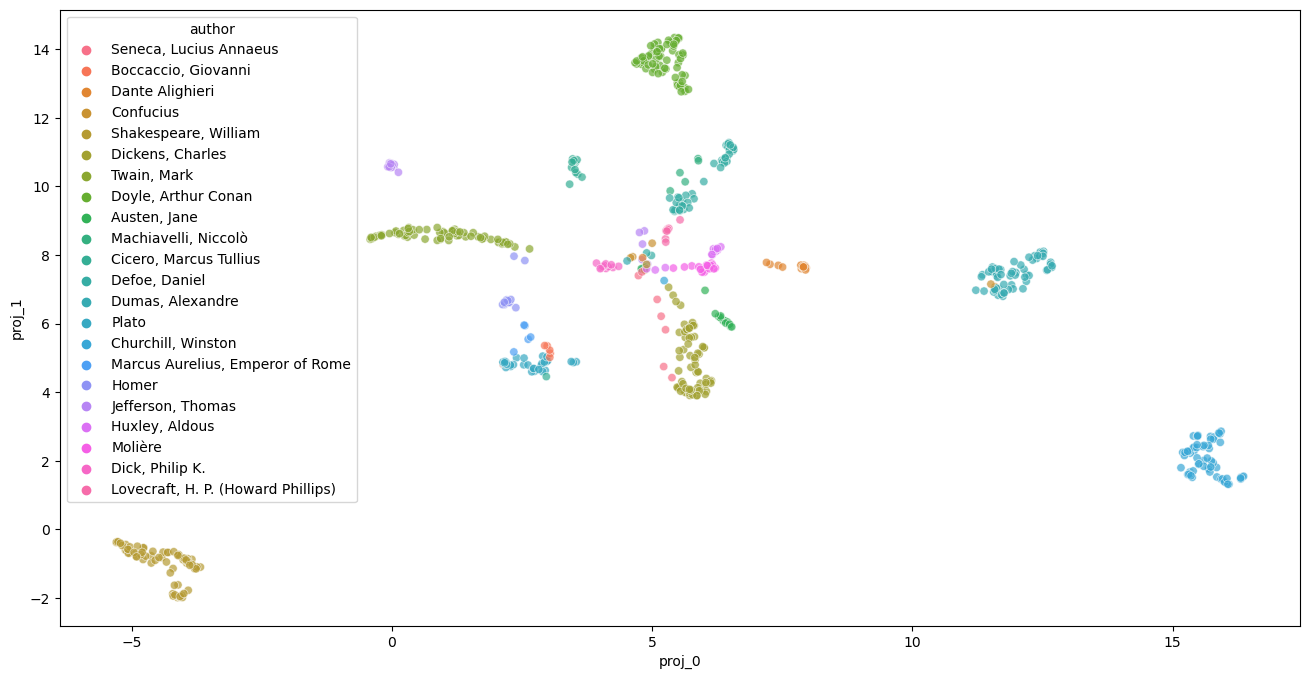

In [16]:
# # old code:
# sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
#                 hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
#                alpha = 0.7);

plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = 'author',
               alpha = 0.7);

In [19]:
library_select['authorcentury'].unique()

array([ 1., 14., 13., -6., 16., 19., 18., 15., -1., -4., 20.,  2., -7.,
       17.])

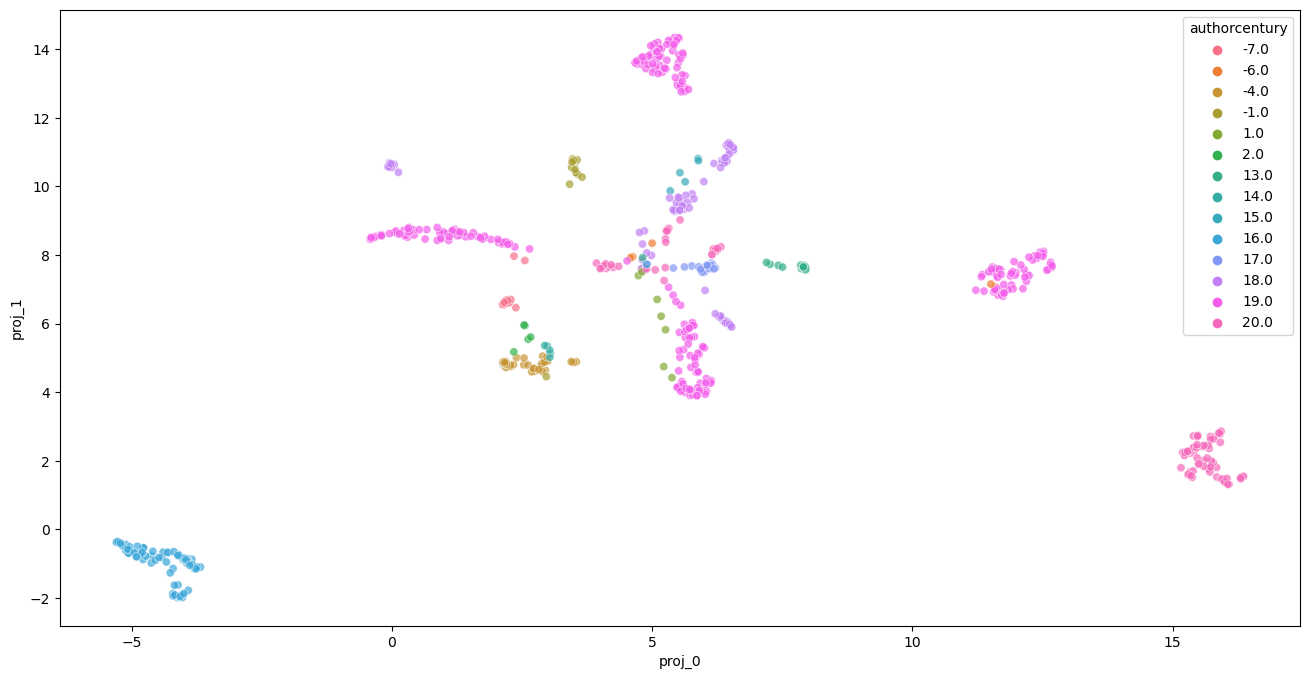

In [24]:
plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = library_select['authorcentury'].astype('category'),
               alpha = 0.7);

## Cosine Similarity

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity - for a first attempt, group it by author.

In [25]:
library_select

,id,title,author,authorcentury,proj_0,proj_1,dim_0,dim_1,dim_2,dim_3,...,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99
1,PG10001,Apocolocyntosis,"Seneca, Lucius Annaeus",1.0,4.735946,7.398473,0.000000,0.000000,0.000000,1.174371,...,0.0,0.000000,0.000000,1.236353,8.067404,0.000000,0.000000,0.000000,3.114843,0.000000
6,PG10006,La Fiammetta,"Boccaccio, Giovanni",14.0,2.139001,4.807032,4.650827,7.380943,0.000000,10.704428,...,0.0,9.150836,1.573807,0.000000,0.000000,8.732283,18.844457,0.000000,0.000000,0.000000
21,PG1001,"Divine Comedy, Longfellow's Translation, Hell",Dante Alighieri,13.0,7.865646,7.701200,0.000000,0.000000,0.000000,7.317742,...,0.0,0.000000,0.000000,0.000000,134.471496,43.788971,0.000000,12.391698,28.683251,0.000000
32,PG1002,"Divine Comedy, Longfellow's Translation, Purga...",Dante Alighieri,13.0,7.958503,7.625683,0.000000,0.000000,27.816074,43.165057,...,0.0,0.000000,0.000000,0.000000,145.247566,13.187849,5.656618,0.000000,17.481764,0.000000
43,PG1003,"Divine Comedy, Longfellow's Translation, Paradise",Dante Alighieri,13.0,7.907661,7.670850,0.000000,0.000000,0.000000,14.967075,...,0.0,0.000000,0.000000,0.000000,128.594934,46.555670,0.000000,13.077090,28.679628,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70047,PG963,Little Dorrit,"Dickens, Charles",19.0,5.650265,4.110567,0.000000,0.000000,5.020278,0.000000,...,0.0,0.000000,0.000000,35.410135,38.928287,54.980755,0.000000,0.000000,0.954131,0.285833
70069,PG965,The Black Tulip,"Dumas, Alexandre",19.0,11.324479,7.364992,0.000000,0.000000,0.000000,21.171795,...,0.0,0.000000,0.000000,4.321702,0.000000,22.024373,17.566489,0.000000,2.263924,0.000000
70091,PG967,Nicholas Nickleby,"Dickens, Charles",19.0,5.748910,4.063621,0.000000,0.000000,0.000000,18.503945,...,0.0,0.000000,0.000000,31.045263,39.880480,53.147345,0.000000,0.000000,0.000000,0.000000
70102,PG968,Martin Chuzzlewit,"Dickens, Charles",19.0,5.717391,4.079775,0.000000,0.000000,0.000000,14.396346,...,0.0,0.636795,0.000000,30.339221,35.075907,53.656886,0.000000,0.000000,1.176565,0.000000


In [26]:
# idea use this to transpose and then see the dist from each book to this point?
library_select_grouped = library_select.drop(columns=['id','title','authorcentury','proj_0','proj_1']).groupby('author').mean()

In [ ]:
dists = spatial.distance.pdist(library_select_grouped.values, metric = 'cosine')